### 필요 library load

In [21]:
import random
import numpy as np
import os
import shutil
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from PIL import Image
from glob import glob
from PIL import Image, ImageDraw, ImageFont, ImageOps
from tqdm import tqdm
import PIL.ImageOps
# imgaug의 시드 고정
ia.seed(42)

In [22]:
"""
image 파일과 label 파일 각각 지정
"""
def route(t):
    file_path = os.path.join("/home/tlrkrwlsmd/yolov5/dataset/images", t)
    pth = []
    for f in os.listdir(file_path):
        pth.append(os.path.join(file_path, f))
    return pth
def annot_route(t):
    file_path = os.path.join("/home/tlrkrwlsmd/yolov5/dataset/labels", t)
    pth = []
    for f in os.listdir(file_path):
        pth.append(os.path.join(file_path, f))
    return pth
pth_tr = route("train")
annot_tr = annot_route("train")

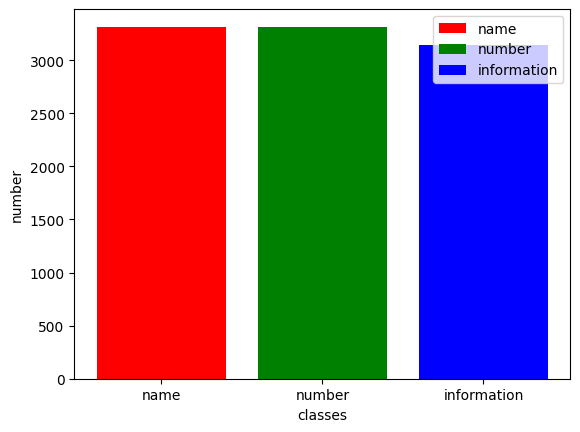

In [43]:
# c0, c1, c2 = 0, 0, 0
# l = []
# for i in annot_tr:
#     with open(i, "r") as f:
#         data = f.readlines()
#         for j in data:
#             l.append(j[0])
# for x in l:
#     if x == "0":
#         c0 += 1
#     elif x == "1":
#         c1 += 1
#     else:
#         c2 += 1
import matplotlib.pyplot as plt

# Assuming you have data for each class
heights = [c0, c1, c2]
classes = ['name', 'number', 'information']
color = ["red", "green", "blue"]

b_g = plt.bar(classes, heights, color = color, label = classes)
plt.xlabel('classes')  # Set x-axis label
plt.ylabel('number')
plt.legend(b_g, classes)
plt.savefig("class_.png")
plt.show()


In [11]:
"""
명함 어그멘테이션을 위한 임시 경로 지정 코드
"""
def path():
    pth_tr = []
    annot_tr = []
    dir_path = "/home/tlrkrwlsmd/adcard_data"
    for file_path in os.listdir(dir_path):
        if os.path.splitext(file_path)[1] == '.png':
            pth_tr.append(os.path.join(dir_path, file_path))
        elif os.path.splitext(file_path)[1] == '.txt':
            annot_tr.append(os.path.join(dir_path, file_path))
    
    return pth_tr, annot_tr

pth_tr, annot_tr = path()

### 총 3가지의 Augmentation을 구현
1. 180°회전(Rotation)
2. Noise 추가
3. 객체를 기준으로 한 Crop
- 특히 Crop과 Rotation의 경우는 이미지 내에서 x, y의 center 좌표가 상대적으로 달라짐에 따라 이를 고려하여 label을 구성

In [14]:
"""
Noise를 추가하는 함수
"""

def make_noise(std, img):
    height, width, ch = img.shape
    # 각 channel에 적용
    # 하나 더 추가
    # 빈 배열 형성
    img_noise = np.zeros((height, width, ch), dtype = np.float64)
    for i in range(height):
        for j in range(width):
            for k in range(ch):
                # gaussian distribution을 따르는 random 숫자를 넣는다
                mk_noise = np.random.normal()
                set_noise = std * mk_noise
                noise_input = img[i][j][k] + set_noise
                if noise_input > 255:
                    noise_input = 255
                if noise_input < 0:
                    noise_input = 255
                img_noise[i][j][k] = noise_input
    return img_noise

In [15]:
"""
객체를 기준으로 Crop하는 함수
"""
def make_crop(img_annot, image):
    with open(img_annot, "r") as f:
        data = f.readlines()
        # cv2는 height, width, channel 순이다.
        img = image
        height, width = img.shape[0], img.shape[1]
        # 각 line에서 xmin, xmax, ymin, ymax를 뽑아낸다.
        xmin = []
        ymin = []
        xmax = []
        ymax = []
        xcenter = []
        ycenter = []
        new_xcenter = []
        new_ycenter = []
        WIDTH = []
        w_l = []
        HEIGHT = []
        h_l = []
        class_no = []
        for line in data:
            info = line.split()
            x_center, y_center, w, h = float(info[1]), float(info[2]), float(info[3]), float(info[4])
            class_no.append(int(line[0]))
            xcenter.append(int(x_center * width))
            ycenter.append(int(y_center * height))
            xmin.append(int((x_center - w/2) * width))
            ymin.append(int((y_center - h/2) * height))
            xmax.append(int((x_center + w/2) * width))
            ymax.append(int((y_center + h/2) * height))
            WIDTH.append(int(w * width))
            HEIGHT.append(int(h * height))
        xmin, ymin, xmax, ymax = min(xmin), min(ymin), max(xmax), max(ymax)
        # crop width
        crop_width = xmax - xmin
        crop_height = ymax - ymin
        for wid in WIDTH:
            if wid/crop_width > 1:
                w_l.append(1.0)
            else:
                w_l.append(wid/crop_width)
        for hei in HEIGHT:
            if hei/crop_height > 1:
                h_l.append(1.0)
            else:
                h_l.append(hei/crop_height)
        for x in xcenter:
            if (x-xmin)/crop_width > 1:
                new_xcenter.append(1.0)
            else:
                new_xcenter.append((x - xmin)/crop_width)
        for y in ycenter:
            if (y-ymin)/crop_height > 1:
                new_ycenter.append(1.0)
            else:
                new_ycenter.append((y - ymin)/crop_height)
    return xmin, ymin, xmax, ymax, xcenter, ycenter, new_xcenter, new_ycenter, w_l, h_l, class_no

In [18]:
def data_augmentation(num, img, annot, n):
    image = cv2.imread(img)
    img_pth = img
    img_annot = annot
    """
    180°회전하는 부분(num == 0)
    """
    if num == 0:
        # annotation file을 읽는다.
        f = open(img_annot)
        bbx = f.readlines()
        # normalize된 것을 복구하기 위한 작업
        d_w = image.shape[1] # 폭
        d_h = image.shape[0] # 높이
        # 하나씩 읽어온다.
        class_no = []
        for i in range(len(bbx)):
            bbxs = bbx[i].split(" ")
            for j in range(len(bbxs)):
                # 이는 class에 해당한다.
                if j == 0:
                    bbxs[j] = int(bbxs[j])
                    class_no.append(int(bbxs[j]))
                # str 형태를 float으로 바꿔온다
                else:
                    x = float(bbxs[j])
                    bbxs[j] = x
            # 대체하는 작업
            bbx[i] = bbxs
        # 작업해야할 bounding box
        bbx_new = []
        for i in range(len(bbx)):
            # 원래의 x_center
            x_center = bbx[i][1] * d_w
            # 원래의 y_center
            y_center = bbx[i][2] * d_h
            # 원래의 폭
            w = bbx[i][3] * d_w
            # 원래의 높이
            h = bbx[i][4] * d_h
            # x1, x2는 각각 boundingbox의 x좌표의 양 끝단
            # y1, y2는 각각 boundingbox의 y좌표의 양 끝단
            x1 = int(x_center - w/2)
            y1 = int(y_center - h/2)
            x2 = int(x_center + w/2)
            y2 = int(y_center + h/2)
            bbx_new.append([x1, y1, x2, y2])
        ia_bbxs = []
        for b in bbx_new:
            ia_bbxs.append(BoundingBox(x1 = b[0], y1 = b[1], x2 = b[2], y2 = b[3]))
        bound_box = BoundingBoxesOnImage(ia_bbxs, shape = image.shape)
        # 180도 회전을 다음과 같이 진행한다.
        seq = iaa.Sequential([iaa.Affine(rotate = 180)])
        # 180도 회전 적용
        img_aug, bbx_aug = seq(image = image, bounding_boxes = bound_box)
        # 이미지를 각 파일에 저장
        storage_dir = os.path.join(img_pth[:45], "rotation_"+str(n)+".png")
        cv2.imwrite(storage_dir, img_aug)
        # 정규화를 시켜서 저장한다.
        annot_file_path = os.path.join(img_annot[:45], "rotation_"+str(n)+".txt")
        with open(annot_file_path, "w") as f:
            for a in range(len(bbx_aug)):
                class_id = class_no[a]
                # opencv의 경우는 높이, 폭, 채널 순서
                dx = 1/int(image.shape[1])
                dy = 1/int(image.shape[0])
                x1 = bbx_aug[a][0][0]
                x2 = bbx_aug[a][1][0]
                y1 = bbx_aug[a][0][1]
                y2 = bbx_aug[a][1][1]
                x_center = (x1+x2)/2 * dx
                y_center = (y1+y2)/2 * dy
                w = (x2-x1) * dx
                h = (y2-y1) * dy
                f.write(f"{class_id} {x_center:.5f} {y_center:.5f} {w:.5f} {h:.5f}\n")
    # Noise 추가
    # 기본적으로 noise로는 Gaussian noise를 추가한다.
    # if num == 1:
    #     noise_img = make_noise(12, image)
    #     storage_dir = os.path.join(img_pth[:14], "noise_"+str(n)+".png")
    #     # 이미지 저장
    #     cv2.imwrite(storage_dir, noise_img)
    #     # annotation 저장
    #     new_annot_file_path = os.path.join(img_annot[:14], "noise_"+str(n)+".txt")
    #     original_annot_path = img_annot
    #     shutil.copyfile(original_annot_path, new_annot_file_path)
    # crop 진행.
    # if num == 2:
    #     # Center 값만 변형 시킨다.
    #     # crop을 한다고 해서 Width와 height가 변하는 것은 아니다
    #     # 시작 기준점이 바뀐다.
    #     mk_annot = make_crop(img_annot, image)
    #     xmin, xmax, ymin, ymax = mk_annot[0], mk_annot[2], mk_annot[1], mk_annot[3]
    #     cropped_image = image[ymin:ymax, xmin:xmax]
    #     storage_dir = os.path.join(img_pth[:45], "cropped_"+str(n)+".png")
    #     cv2.imwrite(storage_dir, cropped_image)
    #     # annotation을 적어야 한다.
    #     annot_file_path = os.path.join(img_annot[:45], "cropped_"+str(n)+".txt")
    #     # new_xcenter, new_ycenter
    #     Xcenter = mk_annot[6]
    #     Ycenter = mk_annot[7]
    #     width_list = mk_annot[8]
    #     height_list = mk_annot[9]
    #     class_no = mk_annot[10]
    #     with open(annot_file_path, "w") as f:
    #         for idx in range(len(class_no)):
    #             class_id = class_no[idx]
    #             x_center = Xcenter[idx]
    #             y_center = Ycenter[idx]
    #             w = width_list[idx]
    #             h = height_list[idx]
    #             f.write(f"{class_id} {x_center:.5f} {y_center:.5f} {w:.5f} {h:.5f}\n")

In [19]:
for n in tqdm(range(len(annot_tr))):
    annot = annot_tr[n]
    imgs = pth_tr[n]
    # num이 0, 1, 2 순서대로 rotation, Gaussian Noise, Crop
    for num in tqdm(range(1)):
        data_augmentation(num, imgs, annot, n)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 127.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 138.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 104.84it/s]

100%|█████████████████████████████████████████████████████████

### 명도, 채도, 대비조정을 통한 증강 기법 적용
- label의 정보는 따로 수정할 필요는 없다.
- label 정보의 이름의 경우만 image 명에 맞춰서 지정해준다.

In [ ]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import shutil
# 밝기 관련
def adjust_brightness(image, factor_range=(0.7, 1.3)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    factor = random.uniform(factor_range[0], factor_range[1])
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# saturation
def adjust_saturation(image, factor_range=(0.7, 1.3)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    factor = random.uniform(factor_range[0], factor_range[1])
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# 대조
def adjust_contrast(image, factor_range=(0.7, 1.3)):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    factor = random.uniform(factor_range[0], factor_range[1])
    lab[:, :, 0] = np.clip(lab[:, :, 0] * factor, 0, 255)
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def apply_augmentation(image):
    # 명도, 채도, 대비 차례대로 적용
    brightened_image = adjust_brightness(image)
    saturated_image = adjust_saturation(brightened_image)
    contrasted_image = adjust_contrast(saturated_image)

    return contrasted_image

# 원본 이미지 파일들이 있는 폴더 경로
input_folder = '/home/tlrkrwlsmd/yolov5/dataset/images/train'
annot_folder = "/home/tlrkrwlsmd/yolov5/dataset/labels/train"

# 증강된 이미지들을 저장할 폴더 경로
output_folder = '/home/tlrkrwlsmd/yolov5/dataset/images/train'
out_folder = '/home/tlrkrwlsmd/yolov5/dataset/labels/train'

# 원본 이미지 파일들의 수를 세기
original_images = [os.path.join('/home/tlrkrwlsmd/yolov5/dataset/images/train',  i) for i in os.listdir(input_folder) if i[-3:] == "jpg"]
annot_files = [os.path.join("/home/tlrkrwlsmd/yolov5/dataset/labels/train", i) for i in os.listdir(annot_folder) if i[0] == 'b']
print(f'현재 원본 파일 개수: {len(original_images)}')

# # 각 원본 파일에 대해 랜덤 어그멘테이션을 적용하고 저장
for p in tqdm(range(len(original_images))):
    pth = original_images[p]
    image = cv2.imread(pth)
    if image is None:
        print("Error: Unable to read the image at path")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 어그멘테이션 적용
    augmented_image = apply_augmentation(image)
    # 저장할 파일명 설정
    output_filename = os.path.join("/home/tlrkrwlsmd/yolov5/dataset/images/train", "augment_"+str(p)+".png")
    annot_filename = os.path.join("/home/tlrkrwlsmd/yolov5/dataset/labels/train", "augment_"+str(p)+".txt")
    # 이미지 저장
    cv2.imwrite(output_filename, augmented_image)
    original_annot_path = annot_files[p]
    shutil.copyfile(original_annot_path, annot_filename)

# # print(f'{num_total_augmentations}개 증강 이미지 생성')

In [20]:
"""
광고 명함 임시 증강
"""
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import shutil
# 밝기 관련
def adjust_brightness(image, factor_range=(0.7, 1.3)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    factor = random.uniform(factor_range[0], factor_range[1])
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# saturation
def adjust_saturation(image, factor_range=(0.7, 1.3)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    factor = random.uniform(factor_range[0], factor_range[1])
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# 대조
def adjust_contrast(image, factor_range=(0.7, 1.3)):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    factor = random.uniform(factor_range[0], factor_range[1])
    lab[:, :, 0] = np.clip(lab[:, :, 0] * factor, 0, 255)
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def apply_augmentation(image):
    # 명도, 채도, 대비 차례대로 적용
    brightened_image = adjust_brightness(image)
    saturated_image = adjust_saturation(brightened_image)
    contrasted_image = adjust_contrast(saturated_image)

    return contrasted_image

# 원본 이미지 파일들이 있는 폴더 경로
input_folder = '/home/tlrkrwlsmd/yolov5/dataset/images/train'
annot_folder = "/home/tlrkrwlsmd/yolov5/dataset/labels/train"

# 증강된 이미지들을 저장할 폴더 경로
output_folder = '/home/tlrkrwlsmd/yolov5/dataset/images/train'
out_folder = '/home/tlrkrwlsmd/yolov5/dataset/labels/train'

# 원본 이미지 파일들의 수를 세기
original_images = [os.path.join('/home/tlrkrwlsmd/yolov5/dataset/images/train',  i) for i in os.listdir(input_folder) if i[-3:] == "jpg"]
annot_files = [os.path.join("/home/tlrkrwlsmd/yolov5/dataset/labels/train", i) for i in os.listdir(annot_folder) if i[0] == 'b']
print(f'현재 원본 파일 개수: {len(original_images)}')

# # 각 원본 파일에 대해 랜덤 어그멘테이션을 적용하고 저장
for p in tqdm(range(len(pth_tr))):
    pth = pth_tr[p]
    image = cv2.imread(pth)
    if image is None:
        print("Error: Unable to read the image at path")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 어그멘테이션 적용
    augmented_image = apply_augmentation(image)
    # 저장할 파일명 설정
    output_filename = os.path.join(pth[:28], "augment_"+str(p)+".png")
    annot_filename = os.path.join(pth[:28], "augment_"+str(p)+".txt")
    # 이미지 저장
    cv2.imwrite(output_filename, augmented_image)
    original_annot_path = annot_tr[p]
    shutil.copyfile(original_annot_path, annot_filename)

# # print(f'{num_total_augmentations}개 증강 이미지 생성')

현재 원본 파일 개수: 1117


 96%|███████████████████████████████████████████████████████████████████████████████████████████▏   | 48/50 [00:00<00:00, 67.06it/s]


IndexError: list index out of range